In [1]:
import torch
from model.desc import ConditionalDiscriminator
from model.gen import UnetGenerator
from model.losses import GeneratorLoss,DiscriminatorLoss 
import random
import numpy as np
from dataset import Maps
from torch.utils.data import DataLoader
from torchvision import transforms
from modules.dataloader import ImagePairDataset
import torch.optim as optim
import transforms as T
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

set_seed(666)

In [3]:
image_size = 256
crop_size = 256
batch_size = 64
epochs = 100
learning_rate = 0.001

In [4]:
transforms = T.Compose([T.Resize((256,256)),
                        T.ToTensor(),
                        T.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])])

dataset = Maps(root='.', transform=transforms, download=False, mode='train')
valdataset = Maps(root='.', transform=transforms, download=False, mode='train')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
valdataloader = DataLoader(valdataset, batch_size=batch_size, shuffle=True)

In [5]:
generator = UnetGenerator().to(device)
#generator.load_state_dict(torch.load('generator_epoch.pth',map_location=device))
discriminator = ConditionalDiscriminator().to(device)
#discriminator.load_state_dict(torch.load('discriminator_epoch.pth',map_location=device))
# optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
# loss functions
g_criterion = GeneratorLoss(alpha=100)
d_criterion = DiscriminatorLoss()

In [6]:
torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)

tensor(0.)

In [7]:
def reverse_normalization(tensor_image):
    # Define the mean and std used for normalization
    mean = torch.tensor([0.5, 0.5, 0.5]).to(tensor_image.device)
    std = torch.tensor([0.5, 0.5, 0.5]).to(tensor_image.device)

    # Reverse normalization: (image * std) + mean
    tensor_image = tensor_image * std[:, None, None] + mean[:, None, None]

    # Convert from (C x H x W) to (H x W x C) for visualization
    image = tensor_image.permute(1, 2, 0).cpu().numpy()

    # Clip values to [0, 1] for visualization
    image = image.clip(0, 1)

    return image

In [8]:
def validate(generator, discriminator, val_dataloader, device, epoch):
    generator.eval()
    discriminator.eval()
    total_g_loss = 0.0
    total_d_loss = 0.0
    count = 0

    with torch.no_grad():
        for in_image, out_image in tqdm(val_dataloader):
            in_image, real = in_image.to(device), out_image.to(device)

            # Generate fake images
            fake = generator(in_image)

            # Discriminator loss
            fake_pred = discriminator(fake, in_image)
            real_pred = discriminator(real, in_image)
            d_loss = d_criterion(fake_pred, real_pred)

            # Generator loss
            fake_pred = discriminator(fake, in_image)
            g_loss = g_criterion(fake, real, fake_pred)

            total_g_loss += g_loss.item()
            total_d_loss += d_loss.item()
            count += 1

    avg_g_loss = total_g_loss / count
    avg_d_loss = total_d_loss / count

    print(f"[Validation] Epoch [{epoch}], G Loss: {avg_g_loss:.4f}, D Loss: {avg_d_loss:.4f}")

    # Save some sample images for visual inspection
    fake_image = fake[0].cpu().detach()
    real_image = real[0].cpu().detach()
    in_image = in_image[0].cpu().detach()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(reverse_normalization(in_image))
    axes[0].set_title("Input")
    axes[1].imshow(real_image.permute(1, 2, 0).clip(0, 1))
    axes[1].set_title("Real")
    axes[2].imshow(fake_image.permute(1, 2, 0).clip(0, 1))
    axes[2].set_title("Generated")
    plt.show()

    return avg_g_loss, avg_d_loss

In [9]:
g_losses = []
d_losses = []

100%|██████████| 18/18 [03:46<00:00, 12.60s/it]


Epoch [1/100], D Loss: 0.6415, G Loss: 27.5705


100%|██████████| 18/18 [03:46<00:00, 12.59s/it]


Epoch [2/100], D Loss: 0.5665, G Loss: 13.2851


100%|██████████| 18/18 [03:48<00:00, 12.70s/it]


Epoch [3/100], D Loss: 0.5339, G Loss: 12.1220


100%|██████████| 18/18 [03:47<00:00, 12.65s/it]


Epoch [4/100], D Loss: 0.5665, G Loss: 11.3728


100%|██████████| 18/18 [03:48<00:00, 12.67s/it]


Epoch [5/100], D Loss: 0.5171, G Loss: 11.2897


100%|██████████| 18/18 [03:43<00:00, 12.42s/it]


Epoch [6/100], D Loss: 0.5891, G Loss: 10.8521


100%|██████████| 18/18 [03:49<00:00, 12.73s/it]


Epoch [7/100], D Loss: 0.4334, G Loss: 11.4322


100%|██████████| 18/18 [03:49<00:00, 12.73s/it]


Epoch [8/100], D Loss: 0.4252, G Loss: 11.6842


100%|██████████| 18/18 [03:50<00:00, 12.83s/it]


Epoch [9/100], D Loss: 0.4069, G Loss: 11.4809


100%|██████████| 18/18 [03:52<00:00, 12.93s/it]


Epoch [10/100], D Loss: 0.3412, G Loss: 11.4826


100%|██████████| 18/18 [03:44<00:00, 12.49s/it]


Epoch [11/100], D Loss: 0.3735, G Loss: 11.6560


100%|██████████| 18/18 [03:46<00:00, 12.60s/it]


Epoch [12/100], D Loss: 0.3739, G Loss: 12.1683


100%|██████████| 18/18 [03:45<00:00, 12.51s/it]


Epoch [13/100], D Loss: 0.4166, G Loss: 11.1579


100%|██████████| 18/18 [03:44<00:00, 12.50s/it]


Epoch [14/100], D Loss: 0.4166, G Loss: 11.7360


100%|██████████| 18/18 [03:47<00:00, 12.65s/it]


Epoch [15/100], D Loss: 0.3743, G Loss: 11.3825


100%|██████████| 18/18 [03:46<00:00, 12.60s/it]


Epoch [16/100], D Loss: 0.3871, G Loss: 11.2191


100%|██████████| 18/18 [03:47<00:00, 12.65s/it]


Epoch [17/100], D Loss: 0.4028, G Loss: 10.8449


100%|██████████| 18/18 [03:48<00:00, 12.67s/it]


Epoch [18/100], D Loss: 0.4003, G Loss: 10.8423


100%|██████████| 18/18 [03:46<00:00, 12.56s/it]


Epoch [19/100], D Loss: 0.3764, G Loss: 10.9187


100%|██████████| 18/18 [00:33<00:00,  1.86s/it]


[Validation] Epoch [19], G Loss: 11.7583, D Loss: 0.5081


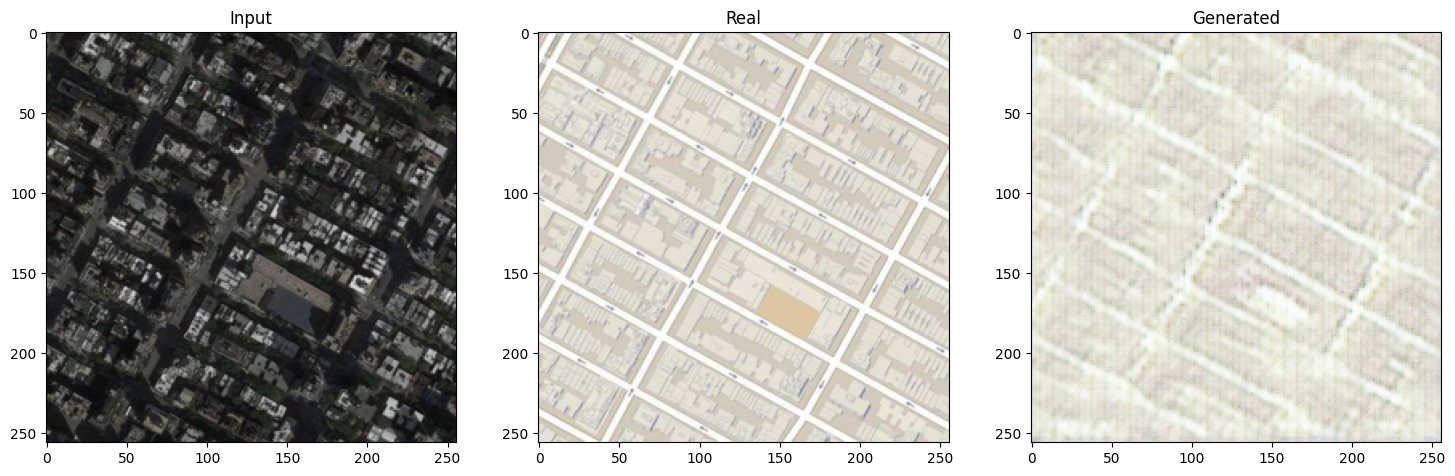

Epoch [20/100], D Loss: 0.4740, G Loss: 10.7540


100%|██████████| 18/18 [03:48<00:00, 12.68s/it]


Epoch [21/100], D Loss: 0.4025, G Loss: 10.2847


100%|██████████| 18/18 [03:47<00:00, 12.66s/it]


Epoch [22/100], D Loss: 0.3884, G Loss: 10.8318


100%|██████████| 18/18 [03:46<00:00, 12.59s/it]


Epoch [23/100], D Loss: 0.4262, G Loss: 10.6838


100%|██████████| 18/18 [03:45<00:00, 12.55s/it]


Epoch [24/100], D Loss: 0.3546, G Loss: 10.7219


100%|██████████| 18/18 [03:44<00:00, 12.49s/it]


Epoch [25/100], D Loss: 0.4214, G Loss: 10.2106


100%|██████████| 18/18 [03:52<00:00, 12.89s/it]


Epoch [26/100], D Loss: 0.4074, G Loss: 10.2839


100%|██████████| 18/18 [03:46<00:00, 12.58s/it]


Epoch [27/100], D Loss: 0.3848, G Loss: 10.2062


100%|██████████| 18/18 [03:44<00:00, 12.46s/it]


Epoch [28/100], D Loss: 0.4698, G Loss: 9.9065


100%|██████████| 18/18 [03:44<00:00, 12.47s/it]


Epoch [29/100], D Loss: 0.3991, G Loss: 10.1166


100%|██████████| 18/18 [03:47<00:00, 12.65s/it]


Epoch [30/100], D Loss: 0.4408, G Loss: 9.9571


100%|██████████| 18/18 [03:47<00:00, 12.65s/it]


Epoch [31/100], D Loss: 0.3699, G Loss: 9.7695


100%|██████████| 18/18 [03:48<00:00, 12.68s/it]


Epoch [32/100], D Loss: 0.4720, G Loss: 9.7419


100%|██████████| 18/18 [03:49<00:00, 12.74s/it]


Epoch [33/100], D Loss: 0.4421, G Loss: 9.4389


100%|██████████| 18/18 [03:53<00:00, 12.98s/it]


Epoch [34/100], D Loss: 0.3540, G Loss: 10.7105


100%|██████████| 18/18 [03:47<00:00, 12.66s/it]


Epoch [35/100], D Loss: 0.4246, G Loss: 9.8438


100%|██████████| 18/18 [03:48<00:00, 12.67s/it]


Epoch [36/100], D Loss: 0.4554, G Loss: 9.7895


100%|██████████| 18/18 [03:46<00:00, 12.58s/it]


Epoch [37/100], D Loss: 0.4036, G Loss: 9.4347


100%|██████████| 18/18 [03:46<00:00, 12.58s/it]


Epoch [38/100], D Loss: 0.4689, G Loss: 9.3165


100%|██████████| 18/18 [03:45<00:00, 12.55s/it]


Epoch [39/100], D Loss: 0.4390, G Loss: 9.3311


100%|██████████| 18/18 [00:29<00:00,  1.66s/it]


[Validation] Epoch [39], G Loss: 9.0666, D Loss: 0.3404


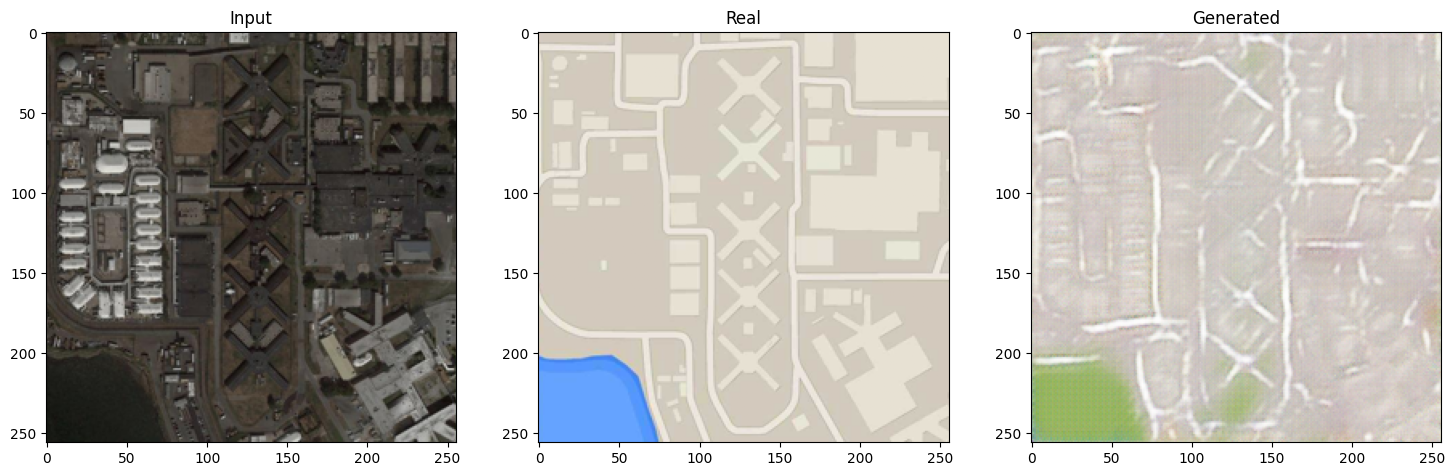

Epoch [40/100], D Loss: 0.4870, G Loss: 9.2363


100%|██████████| 18/18 [03:48<00:00, 12.68s/it]


Epoch [41/100], D Loss: 0.4675, G Loss: 8.6741


100%|██████████| 18/18 [03:47<00:00, 12.64s/it]


Epoch [42/100], D Loss: 0.5333, G Loss: 8.8172


100%|██████████| 18/18 [03:48<00:00, 12.68s/it]


Epoch [43/100], D Loss: 0.4669, G Loss: 8.9320


100%|██████████| 18/18 [03:49<00:00, 12.72s/it]


Epoch [44/100], D Loss: 0.4820, G Loss: 9.0578


100%|██████████| 18/18 [03:46<00:00, 12.58s/it]


Epoch [45/100], D Loss: 0.4861, G Loss: 8.9710


100%|██████████| 18/18 [03:46<00:00, 12.56s/it]


Epoch [46/100], D Loss: 0.4597, G Loss: 8.3752


100%|██████████| 18/18 [03:47<00:00, 12.64s/it]


Epoch [47/100], D Loss: 0.5411, G Loss: 8.4922


100%|██████████| 18/18 [03:47<00:00, 12.61s/it]


Epoch [48/100], D Loss: 0.5202, G Loss: 8.3034


100%|██████████| 18/18 [03:46<00:00, 12.57s/it]


Epoch [49/100], D Loss: 0.4614, G Loss: 8.4215


100%|██████████| 18/18 [03:44<00:00, 12.49s/it]


Epoch [50/100], D Loss: 0.5112, G Loss: 8.0055


100%|██████████| 18/18 [03:43<00:00, 12.42s/it]


Epoch [51/100], D Loss: 0.4980, G Loss: 8.4197


100%|██████████| 18/18 [03:50<00:00, 12.82s/it]


Epoch [52/100], D Loss: 0.4726, G Loss: 8.9645


100%|██████████| 18/18 [03:45<00:00, 12.55s/it]


Epoch [53/100], D Loss: 0.4776, G Loss: 8.3852


100%|██████████| 18/18 [03:44<00:00, 12.46s/it]


Epoch [54/100], D Loss: 0.5438, G Loss: 8.0440


100%|██████████| 18/18 [03:44<00:00, 12.48s/it]


Epoch [55/100], D Loss: 0.5120, G Loss: 7.6568


100%|██████████| 18/18 [03:47<00:00, 12.65s/it]


Epoch [56/100], D Loss: 0.4749, G Loss: 7.8547


100%|██████████| 18/18 [03:48<00:00, 12.67s/it]


Epoch [57/100], D Loss: 0.5580, G Loss: 7.6593


100%|██████████| 18/18 [03:48<00:00, 12.70s/it]


Epoch [58/100], D Loss: 0.5159, G Loss: 7.8160


100%|██████████| 18/18 [03:49<00:00, 12.75s/it]


Epoch [59/100], D Loss: 0.5267, G Loss: 7.6226


100%|██████████| 18/18 [00:31<00:00,  1.76s/it]


[Validation] Epoch [59], G Loss: 24.4761, D Loss: 2.0830


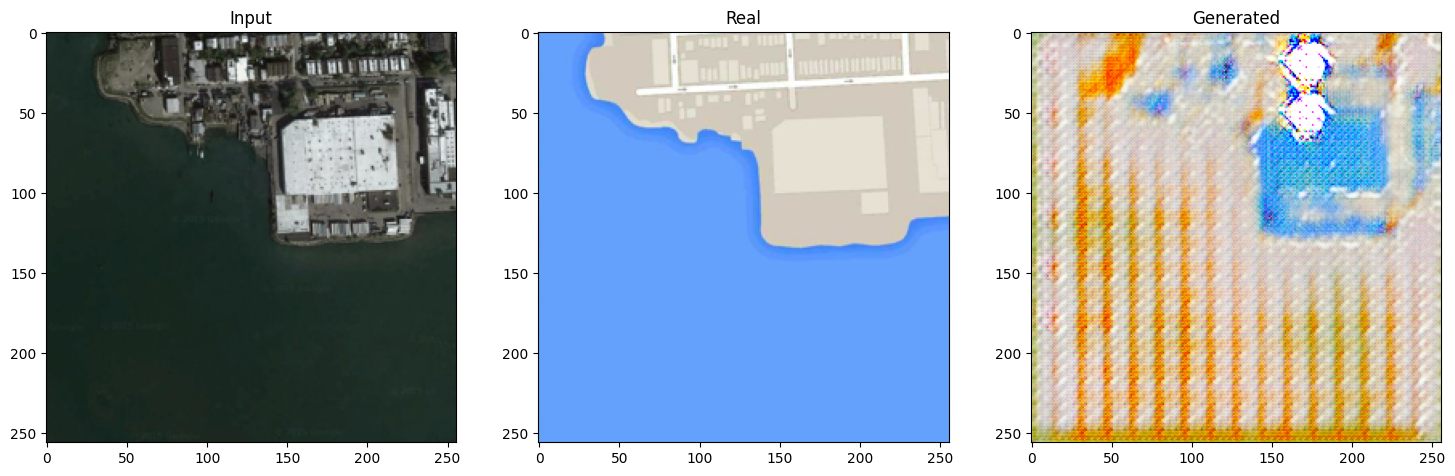

Epoch [60/100], D Loss: 0.4736, G Loss: 7.6667


100%|██████████| 18/18 [03:45<00:00, 12.53s/it]


Epoch [61/100], D Loss: 0.4703, G Loss: 9.5569


100%|██████████| 18/18 [03:48<00:00, 12.67s/it]


Epoch [62/100], D Loss: 0.5658, G Loss: 7.8331


100%|██████████| 18/18 [03:46<00:00, 12.60s/it]


Epoch [63/100], D Loss: 0.4753, G Loss: 8.1592


100%|██████████| 18/18 [03:47<00:00, 12.66s/it]


Epoch [64/100], D Loss: 0.4891, G Loss: 7.9296


100%|██████████| 18/18 [03:47<00:00, 12.63s/it]


Epoch [65/100], D Loss: 0.5076, G Loss: 7.9843


100%|██████████| 18/18 [03:46<00:00, 12.61s/it]


Epoch [66/100], D Loss: 0.5409, G Loss: 7.4016


100%|██████████| 18/18 [03:49<00:00, 12.74s/it]


Epoch [67/100], D Loss: 0.5102, G Loss: 7.3804


100%|██████████| 18/18 [03:48<00:00, 12.70s/it]


Epoch [68/100], D Loss: 0.5101, G Loss: 7.4033


100%|██████████| 18/18 [03:49<00:00, 12.78s/it]


Epoch [69/100], D Loss: 0.5246, G Loss: 7.7349


100%|██████████| 18/18 [03:49<00:00, 12.77s/it]


Epoch [70/100], D Loss: 0.5173, G Loss: 7.8135


100%|██████████| 18/18 [03:46<00:00, 12.59s/it]


Epoch [71/100], D Loss: 0.5308, G Loss: 7.3496


100%|██████████| 18/18 [03:45<00:00, 12.55s/it]


Epoch [72/100], D Loss: 0.5305, G Loss: 7.2732


100%|██████████| 18/18 [03:47<00:00, 12.63s/it]


Epoch [73/100], D Loss: 0.4852, G Loss: 7.2513


100%|██████████| 18/18 [03:47<00:00, 12.64s/it]


Epoch [74/100], D Loss: 0.4806, G Loss: 8.2208


100%|██████████| 18/18 [03:46<00:00, 12.57s/it]


Epoch [75/100], D Loss: 0.5467, G Loss: 7.6272


100%|██████████| 18/18 [03:45<00:00, 12.53s/it]


Epoch [76/100], D Loss: 0.4403, G Loss: 7.4745


100%|██████████| 18/18 [03:44<00:00, 12.47s/it]


Epoch [77/100], D Loss: 0.5217, G Loss: 7.3311


100%|██████████| 18/18 [03:51<00:00, 12.87s/it]


Epoch [78/100], D Loss: 0.5114, G Loss: 7.1051


100%|██████████| 18/18 [03:46<00:00, 12.56s/it]


Epoch [79/100], D Loss: 0.5243, G Loss: 7.0380


100%|██████████| 18/18 [00:29<00:00,  1.65s/it]


[Validation] Epoch [79], G Loss: 9.7710, D Loss: 0.3598


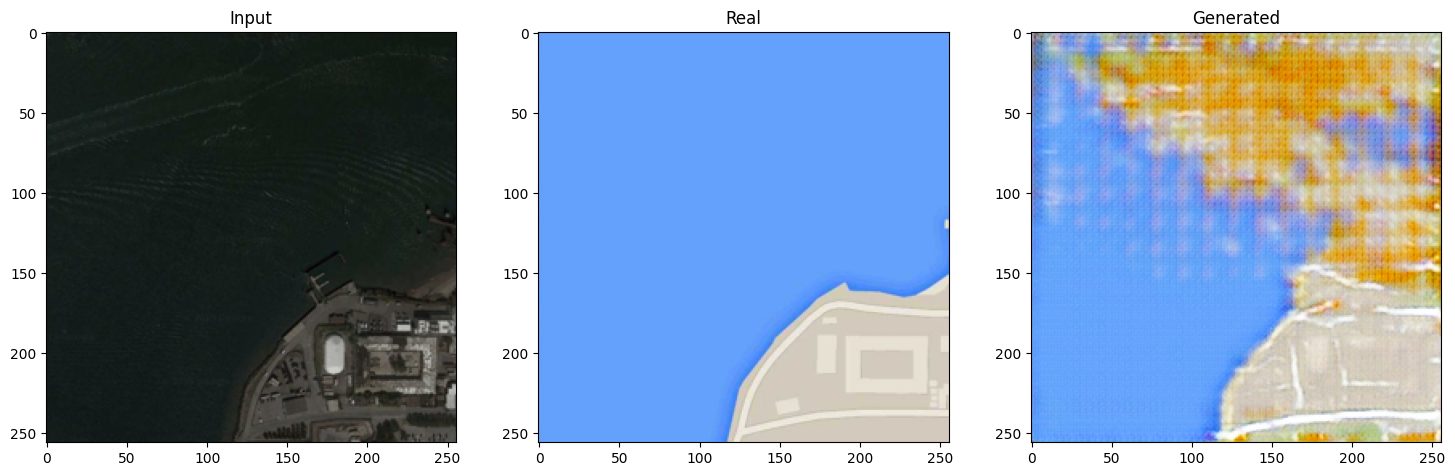

Epoch [80/100], D Loss: 0.4591, G Loss: 7.4056


100%|██████████| 18/18 [03:44<00:00, 12.49s/it]


Epoch [81/100], D Loss: 0.5626, G Loss: 7.2497


100%|██████████| 18/18 [03:48<00:00, 12.67s/it]


Epoch [82/100], D Loss: 0.5305, G Loss: 7.2129


100%|██████████| 18/18 [03:48<00:00, 12.67s/it]


Epoch [83/100], D Loss: 0.4711, G Loss: 7.3008


100%|██████████| 18/18 [03:48<00:00, 12.69s/it]


Epoch [84/100], D Loss: 0.5630, G Loss: 7.0934


100%|██████████| 18/18 [03:49<00:00, 12.75s/it]


Epoch [85/100], D Loss: 0.5040, G Loss: 6.9013


100%|██████████| 18/18 [03:46<00:00, 12.61s/it]


Epoch [86/100], D Loss: 0.5554, G Loss: 7.0044


100%|██████████| 18/18 [03:46<00:00, 12.59s/it]


Epoch [87/100], D Loss: 0.8353, G Loss: 6.4071


100%|██████████| 18/18 [03:47<00:00, 12.63s/it]


Epoch [88/100], D Loss: 0.4985, G Loss: 6.1842


100%|██████████| 18/18 [03:46<00:00, 12.56s/it]


Epoch [89/100], D Loss: 0.5355, G Loss: 6.5796


100%|██████████| 18/18 [03:46<00:00, 12.59s/it]


Epoch [90/100], D Loss: 0.4814, G Loss: 6.4272


100%|██████████| 18/18 [03:46<00:00, 12.56s/it]


Epoch [91/100], D Loss: 0.5295, G Loss: 6.8713


100%|██████████| 18/18 [03:46<00:00, 12.58s/it]


Epoch [92/100], D Loss: 0.4945, G Loss: 6.5165


100%|██████████| 18/18 [03:49<00:00, 12.73s/it]


Epoch [93/100], D Loss: 0.5583, G Loss: 6.6903


100%|██████████| 18/18 [03:47<00:00, 12.66s/it]


Epoch [94/100], D Loss: 0.4543, G Loss: 6.7785


100%|██████████| 18/18 [03:49<00:00, 12.78s/it]


Epoch [95/100], D Loss: 0.5129, G Loss: 7.0013


100%|██████████| 18/18 [03:49<00:00, 12.74s/it]


Epoch [96/100], D Loss: 0.4675, G Loss: 7.2816


100%|██████████| 18/18 [03:46<00:00, 12.56s/it]


Epoch [97/100], D Loss: 0.4795, G Loss: 7.8368


100%|██████████| 18/18 [03:46<00:00, 12.59s/it]


Epoch [98/100], D Loss: 0.4548, G Loss: 7.2898


100%|██████████| 18/18 [03:47<00:00, 12.67s/it]


Epoch [99/100], D Loss: 0.4318, G Loss: 6.9922


100%|██████████| 18/18 [00:30<00:00,  1.69s/it]


[Validation] Epoch [99], G Loss: 10.9064, D Loss: 0.3842


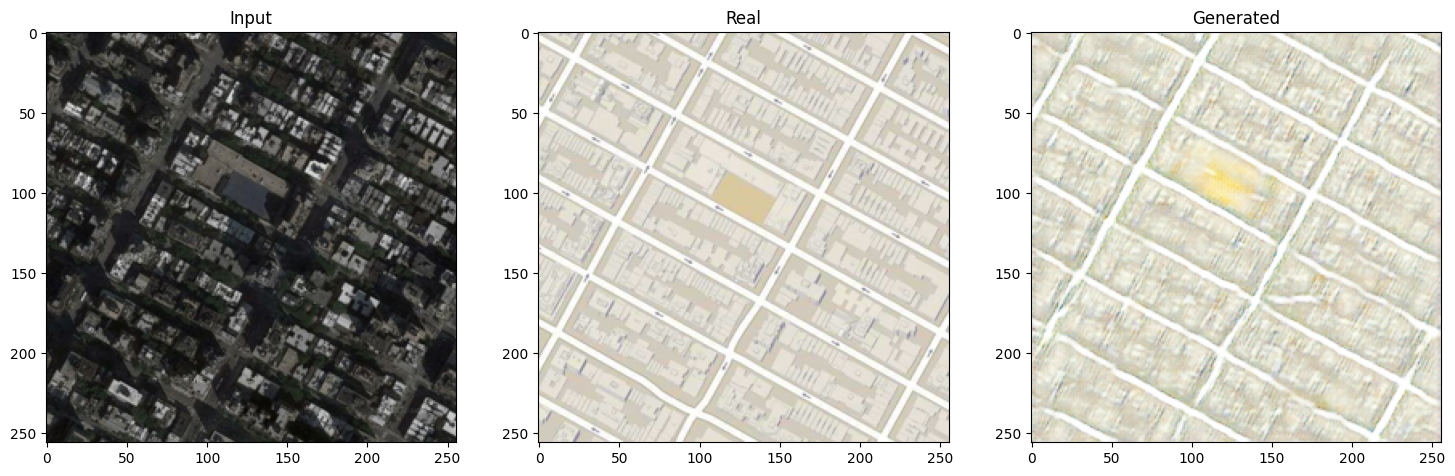

Epoch [100/100], D Loss: 0.3944, G Loss: 7.8634
Обучение завершено.


In [10]:
for epoch in range(epochs):
    generator.train()
    discriminator.train()

    running_loss_g = 0.0
    running_loss_d = 0.0

    for in_image, out_image in tqdm(dataloader):
        x, real = in_image.to(device), out_image.to(device)

        x = x.to(device)
        real = real.to(device)

        fake = generator(x)
        fake_pred = discriminator(fake, x)
        g_loss = g_criterion(fake, real, fake_pred)

        # Discriminator`s loss
        fake = fake.detach()
        fake_pred = discriminator(fake, x)
        real_pred = discriminator(real, x)
        d_loss = d_criterion(fake_pred, real_pred)

        # Generator`s params update
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Discriminator`s params update
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        # add batch losses
        running_loss_g += g_loss.item()
        running_loss_d += d_loss.item()

    g_losses.append(running_loss_g / len(dataloader))
    d_losses.append(running_loss_d / len(dataloader))

    # Print results and save images every 10 epochs
    if (epoch + 1) % 20 == 0:
        val_g_loss, val_d_loss = validate(generator, discriminator, valdataloader, device, epoch)
        # Save the generator model
    torch.save(generator.state_dict(), 'generator_epoch.pth')
    torch.save(discriminator.state_dict(),'discriminator_epoch.pth')

    # Print losses
    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {running_loss_d/len(dataloader):.4f}, G Loss: {running_loss_g/len(dataloader):.4f}")

print("Обучение завершено.")

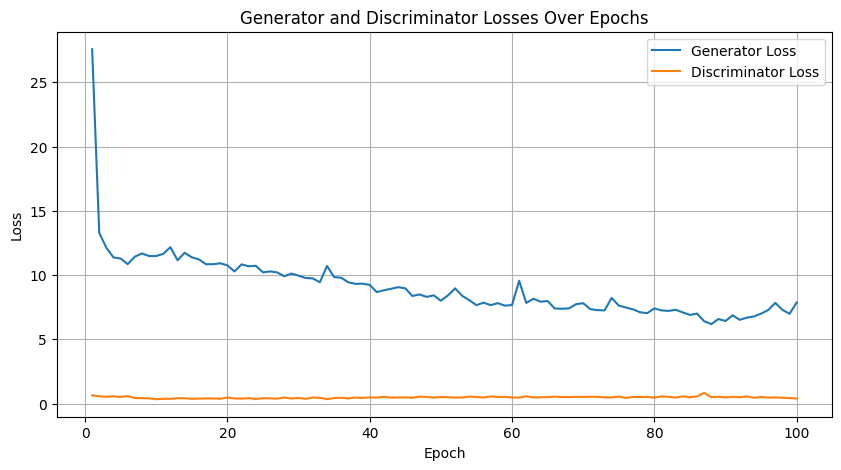

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), g_losses, label="Generator Loss")
plt.plot(range(1, epochs + 1), d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Losses Over Epochs")
plt.legend()
plt.grid()
plt.show()